# Asphalt Pavements Performance Prediction Using Tree Ensemble Models

## TLDR
Predict the performance of flexible pavements, specifically the International Roughness Index (IRI), using various Tree Ensemble models.

## Overview:
This notebook contains the code used to train and compare five Tree Ensemble models, namely Random Forest, Gradient Boosting Decision Tree, XGBoost, and CatBoost, for predicting asphalt pavement performance (using IRI as a target). The models are trained using the Long-Term Pavement Performance (LTPP) program data.

## Data Availability:
The dataset used in this study is available at [https://infopave.fhwa.dot.gov/DownloadTracker/Bucket/114229](https://infopave.fhwa.dot.gov/DownloadTracker/Bucket/114229).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

%matplotlib inline

# Improve quality of images
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400
sns.set(rc={"figure.dpi":400, 'savefig.dpi':400})
sns.set_context('notebook')
sns.set_style("ticks")


In [2]:
# Regressors
DT_reg = DecisionTreeRegressor(random_state=42, max_depth=4)
RF_reg = RandomForestRegressor(random_state=42, max_depth=4)
GBDT_reg = GradientBoostingRegressor(random_state=42, max_depth=4)
XG_reg = xgb.XGBRegressor(random_state=42, max_depth=4)
CB_reg = CatBoostRegressor(random_state=42, depth=4, verbose=0)  # verbose=0 to turn off training output


In [3]:
# Load data
df = pd.read_csv('data/processed/data.csv')

In [4]:
df.head()

YEAR   SN     IRI STATION_ID  AGE  ACCUMULATED_AADTT  MEDIAN_PRECIPITATION  \
0  1989  6.1  0.8984    34_1638  4.0             1190.0           1372.800049   
1  1990  6.1  0.9420    34_1638  5.0             2440.0           1254.900024   
2  1991  6.1  0.9394    34_1638  6.0             3870.0           1189.866699   
3  1992  6.1  0.8992    34_1638  7.0             5485.0           1122.825028   
4  1993  6.1  0.9228    34_1638  8.0             6631.0           1136.980017   

   MEDIAN_TEMPERATURE  
0           12.000000  
1           12.900000  
2           13.233333  
3           12.975000  
4           12.960000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   YEAR                  612 non-null    int64  
 1   SN                    612 non-null    float64
 2   IRI                   612 non-null    float64
 3   STATION_ID            612 non-null    object 
 4   AGE                   612 non-null    float64
 5   ACCUMULATED_AADTT     612 non-null    float64
 6   MEDIAN_PRECIPITATION  612 non-null    float64
 7   MEDIAN_TEMPERATURE    612 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 38.4+ KB


In [6]:
# Rename columns
df = df.rename({'ACCUMULATED_AADTT': 'AADTT',
                    'MEDIAN_PRECIPITATION': 'PRECIPITATION',
                    'MEDIAN_TEMPERATURE': 'TEMPERATURE',
                    }, axis=1)

In [7]:
df.describe().T

count         mean          std          min          25%  \
YEAR           612.0  1996.338235     5.160118  1989.000000  1992.000000   
SN             612.0     4.563725     1.539090     2.000000     3.600000   
IRI            612.0     1.388706     0.612876     0.620800     0.906400   
AGE            612.0    16.070261     7.434381     1.000000    10.000000   
AADTT          612.0  2998.134259  4019.191719    11.000000   668.500000   
PRECIPITATION  612.0  1049.111757   434.257320    92.199997   676.195319   
TEMPERATURE    612.0    15.361542     6.130644     3.700000     9.916072   

                       50%          75%         max  
YEAR           1995.500000  1999.000000   2016.0000  
SN                4.200000     5.500000      8.3000  
IRI               1.188500     1.742700      4.0048  
AGE              15.500000    21.000000     38.0000  
AADTT          1553.500000  3665.875000  27470.0000  
PRECIPITATION  1138.391231  1420.886281   1828.7500  
TEMPERATURE      16.202778    19.445238     25.6000

In [8]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 30000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 50 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='ticks', font_scale=1.6)

g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
# g.savefig('results/scatter_matrixSNS.png')

/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

In [9]:
# Split into target and dataset
y = df['IRI']  # target
X = df.drop(['IRI', 'STATION_ID'], axis=1)

In [10]:
X.shape, y.shape

((612, 6), (612,))

In [11]:
# Split in 75/25 (train/test)
train_threshold = 0.75

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_threshold, random_state=0)

In [12]:
# Train models
DT_reg.fit(X_train, y_train)
RF_reg.fit(X_train, y_train)
XG_reg.fit(X_train, y_train)
GBDT_reg.fit(X_train, y_train)
CB_reg.fit(X_train, y_train)
print('Data trained! =)')

/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future 

Data trained! =)


In [13]:
# Predict results
resultDT = DT_reg.predict(X_test)
resultRF = RF_reg.predict(X_test)
resultGBDT = GBDT_reg.predict(X_test)
resultXG = XG_reg.predict(X_test)
resultCB = CB_reg.predict(X_test)
print('Predicted! =)')

Predicted! =)


/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/t1/repos/predict-iri-ensamble-trees/venv/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future 

In [14]:
features = X_test.columns

importance_RF = RF_reg.feature_importances_
importance_GBDT = GBDT_reg.feature_importances_
importance_XG = XG_reg.feature_importances_
importance_CB = CB_reg.get_feature_importance()
normalized_importance_CB = (importance_CB / sum(importance_CB)) 

data = {
    'Features': features,
    'RF': (importance_RF * 100).astype(int),
    'GBDT': (importance_GBDT * 100).astype(int),
    'XGBoost': (importance_XG * 100).astype(int),
    'CatBoost': (normalized_importance_CB * 100).astype(int)
}

df_importances = pd.DataFrame(data).set_index('Features')
df_importances_T = df_importances.T
df_importances_T


Features  YEAR  SN  AGE  AADTT  PRECIPITATION  TEMPERATURE
RF          11   6    5      3             22           49
GBDT         9  12    4      5             20           47
XGBoost      9  14    6      5             31           33
CatBoost     8  13    5      7             25           38

In [15]:
# Metrics
def r2(y_test, y_pred):
    return round(r2_score(y_test, y_pred), 2)

def rmse(y_test, y_pred):
    return round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)

def mae(y_test, y_pred):
    return round(mean_absolute_error(y_test, y_pred), 2)

# r2
r2RF = r2(y_test, resultRF)
r2GBDT = r2(y_test, resultGBDT)  
r2XG = r2(y_test, resultXG)
r2CB = r2(y_test, resultCB)

# rmse
rmseRF = rmse(y_test, resultRF)
rmseGBDT = rmse(y_test, resultGBDT)  
rmseXG = rmse(y_test, resultXG)
rmseCB = rmse(y_test, resultCB)

# MAE
maeRF = mae(y_test, resultRF)
maeGBDT = mae(y_test, resultGBDT)  
maeXG = mae(y_test, resultXG)
maeCB = mae(y_test, resultCB)

In [16]:
data = {
    'Model': ['Random Forest (RF)', 'Gradient Boosting Decision Trees (GBDT)', 'XGBoost', 'CatBoost'],
    'R2': [r2RF, r2GBDT, r2XG, r2CB],
    'RMSE': [rmseRF, rmseGBDT, rmseXG, rmseCB],
    'MAE': [maeRF, maeGBDT, maeXG, maeCB]
}

df_metrics = pd.DataFrame(data)
df_metrics

Model    R2  RMSE   MAE
0                       Random Forest (RF)  0.54  0.40  0.32
1  Gradient Boosting Decision Trees (GBDT)  0.87  0.22  0.13
2                                  XGBoost  0.88  0.21  0.12
3                                 CatBoost  0.89  0.20  0.11

In [17]:
# calc. of samples
n_train = int(X.shape[0]*train_threshold)
n_test = int(X.shape[0])-n_train

In [18]:
# np.shape(TreeRegResult)[0]
x = np.arange(np.shape(y_test)[0])

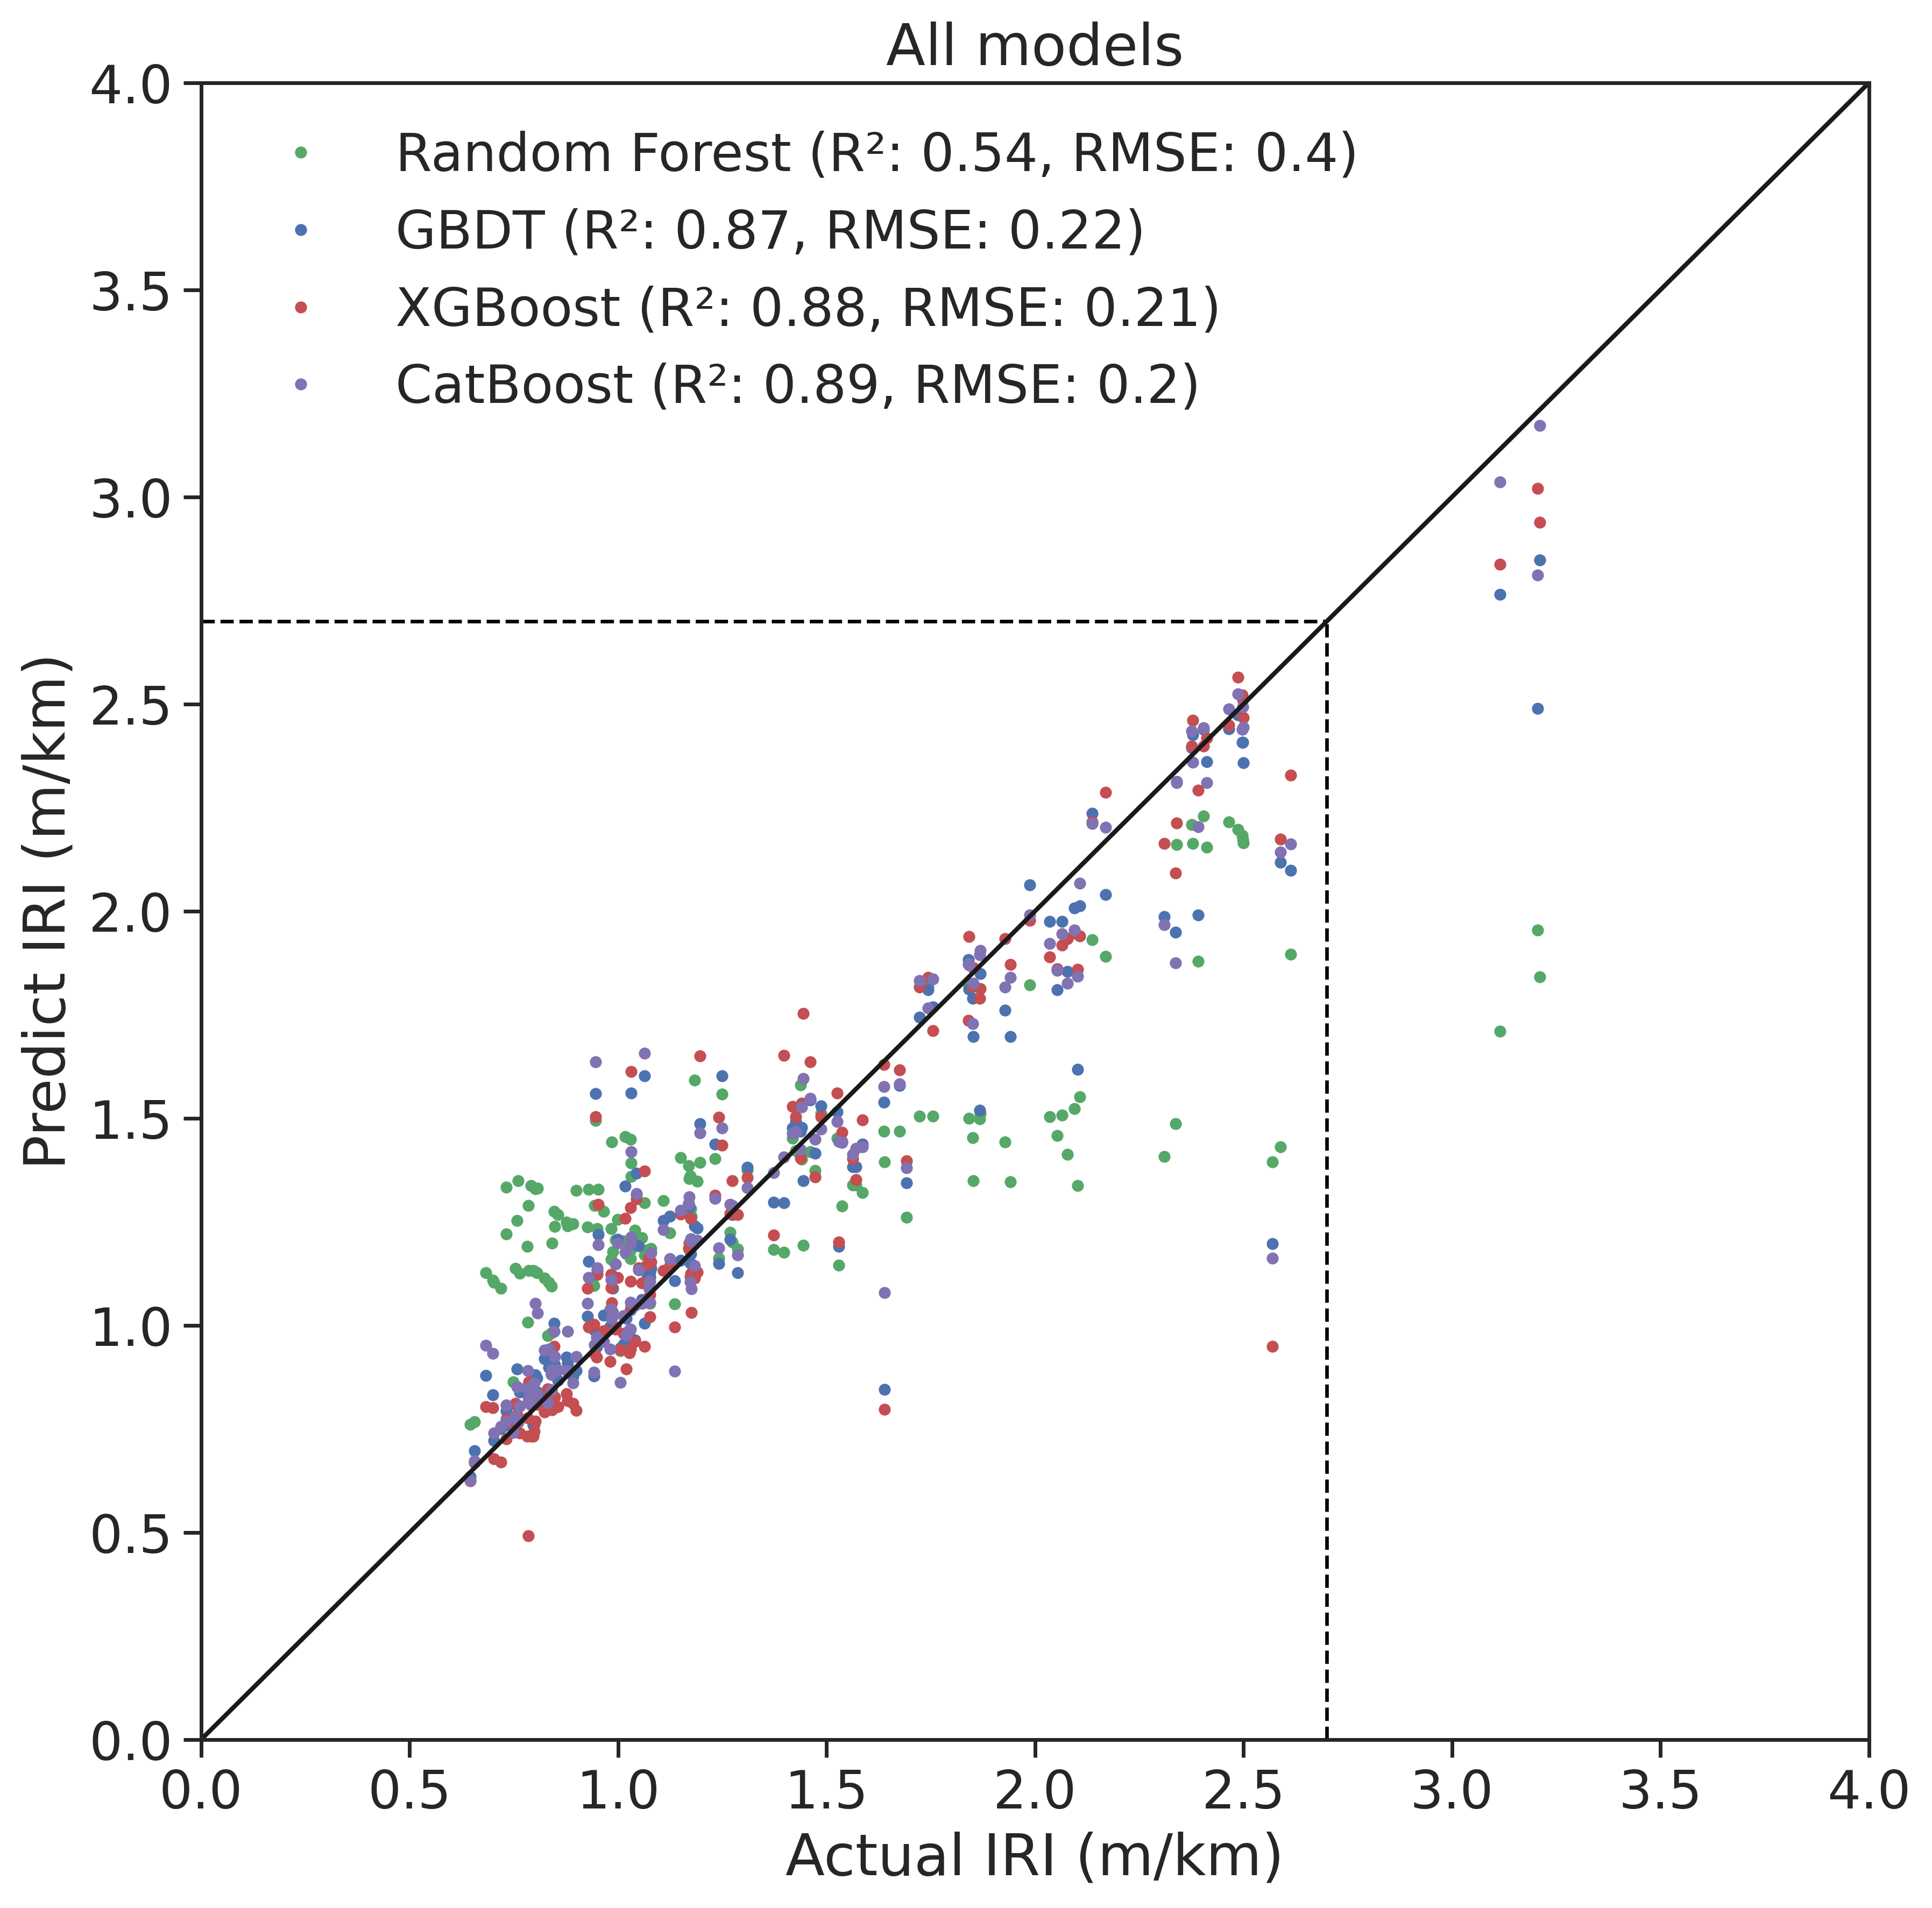

In [22]:
# plot all results
plt.rcParams['figure.figsize'] = (10, 10)

plt.plot(y_test, resultRF, 'g.', label=f'Random Forest (R²: {r2RF}, RMSE: {rmseRF})')
plt.plot(y_test, resultGBDT, 'b.', label=f'GBDT (R²: {r2GBDT}, RMSE: {rmseGBDT})')
plt.plot(y_test, resultXG, 'r.', label=f'XGBoost (R²: {r2XG}, RMSE: {rmseXG})')
plt.plot(y_test, resultCB, 'm.', label=f'CatBoost (R²: {r2CB}, RMSE: {rmseCB})')

plt.hlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)
plt.vlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)

# Add '2.7' text on both x and y axes
# plt.text(2.7, -0.3, '2.7', horizontalalignment='center', fontsize=11) # For x-axis
# plt.text(-0.2, 2.7, '2.7', verticalalignment='center', fontsize=11)   # For y-axis

plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predict IRI (m/km)')

x = np.linspace(0, 4, 100)
plt.plot(x, x, 'k-')  # identity line

plt.axis([0, 4, 0, 4])
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.title("All models")
# plt.savefig('results/treesComparison.png')
plt.show()
